In [1]:
!pip install pycoingecko
!pip install icecream
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install seaborn

In [76]:
from pycoingecko import CoinGeckoAPI
from icecream import ic
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import style
import seaborn as sns

cg = CoinGeckoAPI()

### Getting Top 200 coins' data (sorted by the largest market capitalization) 

In [3]:
coins = cg.get_coins_markets(vs_currency='usd', order='market_cap_desc', per_page=250)[:200]

In [4]:
import time
coins_data = []

# TODO: could be improved with multi threaded async fetchs
for idx, coin in enumerate(coins):
    data = cg.get_coin_market_chart_by_id(coin['id'], 'usd', 90, interval='hourly')
    coins_data.append([coin['id'], data])
    if idx % 25 == 0 and idx != 0:
        print (f"{idx}th Coin data downloaded")
    if idx % 50 == 0 and idx != 0: # free API has a rate limit of 100 calls per minute
        time.sleep(30) 

0th Coin data downloaded
10th Coin data downloaded
20th Coin data downloaded
30th Coin data downloaded
40th Coin data downloaded
50th Coin data downloaded
60th Coin data downloaded
70th Coin data downloaded
80th Coin data downloaded
90th Coin data downloaded
100th Coin data downloaded
110th Coin data downloaded
120th Coin data downloaded
130th Coin data downloaded
140th Coin data downloaded
150th Coin data downloaded
160th Coin data downloaded
170th Coin data downloaded
180th Coin data downloaded
190th Coin data downloaded


### Visualizing Price, Daily Mean Price and Daily Std Price for selected coins


There are mutiple ways to defined volatility, I have picked following defination which I think was most suitable in terms of crpytocurrency.

Daily Volatility is defined as Standard variance over Daily Values (https://www.wallstreetmojo.com/volatility-formula/)

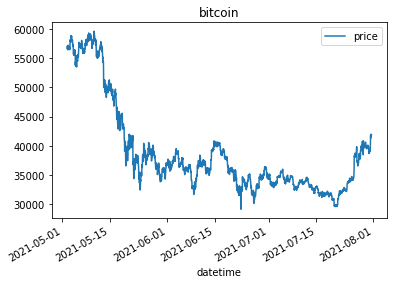

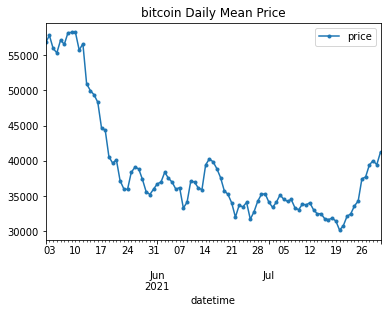

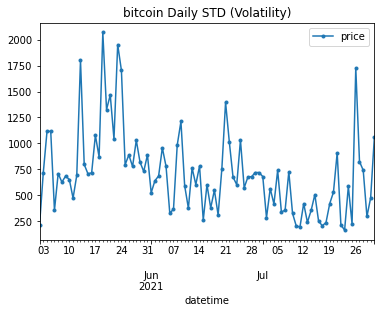

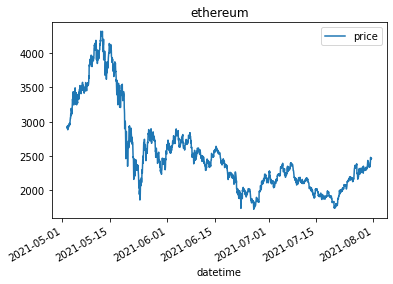

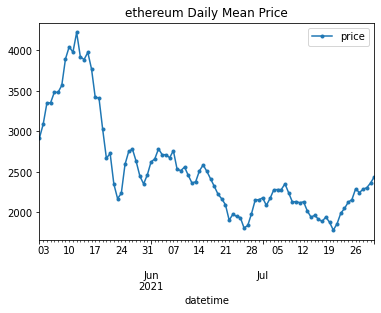

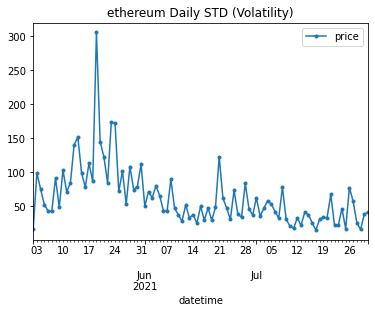

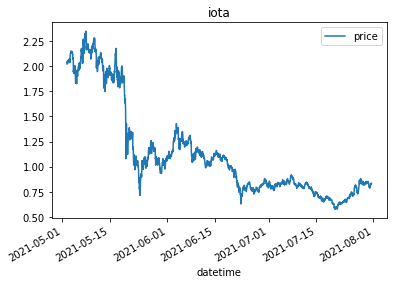

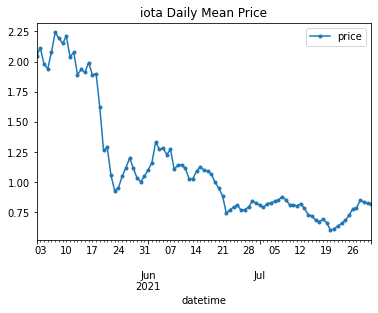

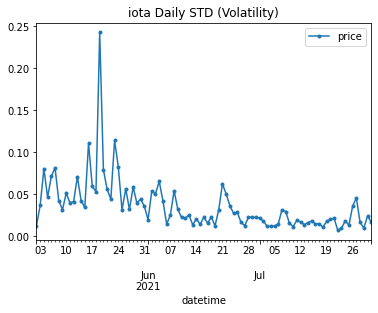

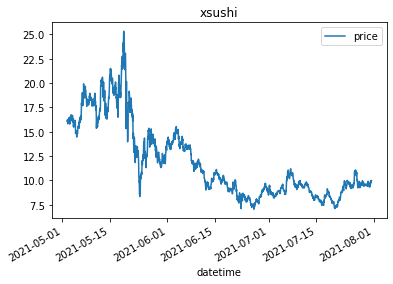

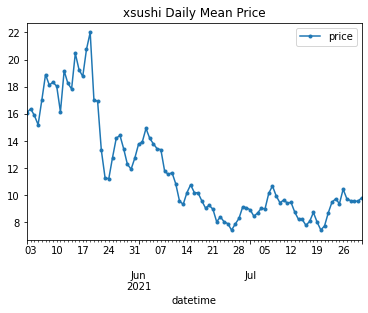

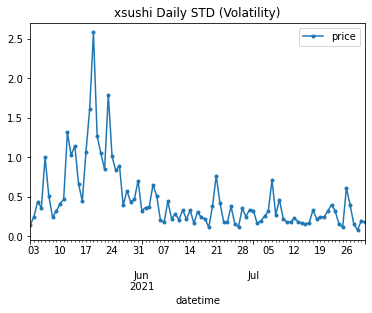

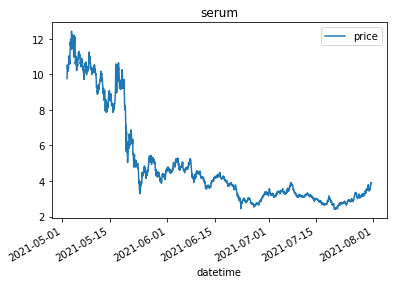

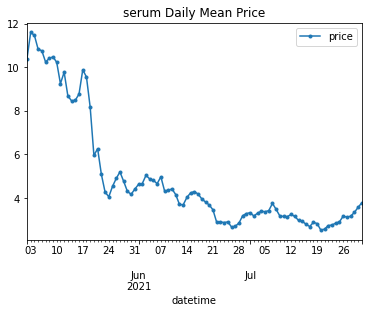

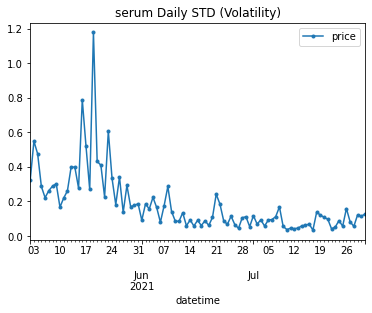

In [77]:
from collections import defaultdict
# create pandas frame form given coin data
def get_hourly_dataframe(coin_data, col_name='price'):
    coin_price = coin_data['prices']
    grouped_by_date = defaultdict(list)
    data = []
    for timestamp, price in coin_price:
        dtime = datetime.fromtimestamp(timestamp / 1000)
        data.append([dtime, price])
        
    df = pd.DataFrame(data, columns=['datetime', col_name])
    df = df.set_index(['datetime'])
    return df

# plotting prices, avg price and Daily STD (Volatility)
def visualize_data(df, name):
    df.plot(title=name)
    avg_price_df = df.groupby(pd.Grouper(freq='D')).mean()
    avg_price_df.plot(title=f'{name} Daily Mean Price', style='.-')
    std_df = df.groupby(pd.Grouper(freq='D')).std()
    std_df.plot(title=f'{name} Daily STD (Volatility)', style='.-')


nth_coins = [0, 1, 49, 99, 199] # 0-based index

for coin_idx in nth_coins:
    coin_name, coin_data = coins_data[coin_idx]
    df = get_hourly_dataframe(coin_data)
    visualize_data(df, coin_name)

In [78]:
clustering_data = [] # daily volatility
avg_price_data = []

for coin_idx in range(len(coins_data)):
    coin_name, coin_data = coins_data[coin_idx]
    df = get_hourly_dataframe(coin_data)
    if len(df.groupby(pd.Grouper(freq='D'))) == 91: # filetering any coin present in list which has less than 90 days data
        clustering_data.append(df.groupby(pd.Grouper(freq='D')).std()['price'].tolist())
        avg_price_data.append(df.groupby(pd.Grouper(freq='D')).mean()['price'].tolist())

In [79]:
import numpy as np
clustering_data_np = np.array(clustering_data)
avg_price_data_np = np.array(avg_price_data)

### Top 10 coins' Volatility cross-correlation 

By plotting cross correlation, we can see that top 10 crpyto currencies' daily Volatility is highly correlated except one coin which is dogecoin.

<AxesSubplot:>

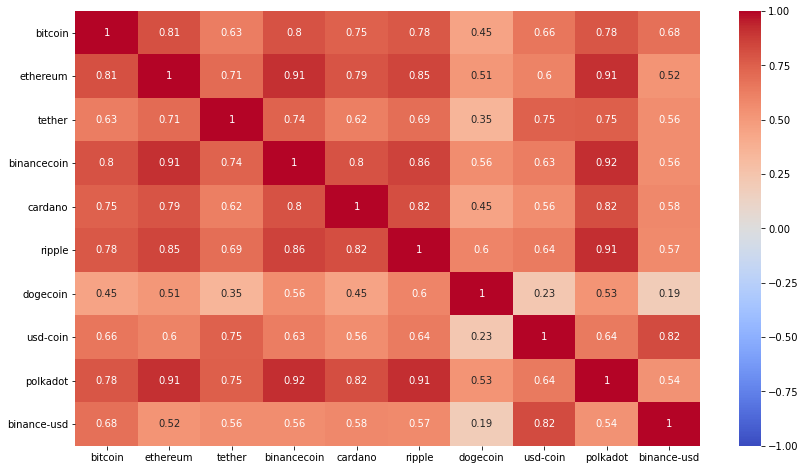

In [9]:
plt.figure(figsize=(14,8))
cross_df = pd.DataFrame(clustering_data_np[:10].T)
sns.heatmap(cross_df.corr(),vmin=-1, vmax=1, cmap='coolwarm', annot=True, xticklabels=[coins_data[i][0] for i in range(10)], yticklabels=[coins_data[i][0] for i in range(10)])

In [75]:
# # plt.figure(figsize=(15,10))
# sns.jointplot(get_hourly_dataframe(coins_data[0][1])['price'], get_hourly_dataframe(coins_data[1][1])['price'], kind="reg")
# # plt.xlabel(coins_data[0][0])
# # plt.ylabel(coins_data[1][0])
# plt.show()

### Clustering based on Volatility and Dimension reduction

Each coin has 90 daily volatility values and based on those value KMeans clustering is applied. (imagine 90-dim vector (time series data) for each coin)

ELbow method is used to find optimal number of cluster.

We can clearly see from result that only few crypto (Bitcoin, wrapped-bitcoin, havven ..) are outlier to normal trend of volatility. 

PCA is used to reduce dimension for visualizing clusters.

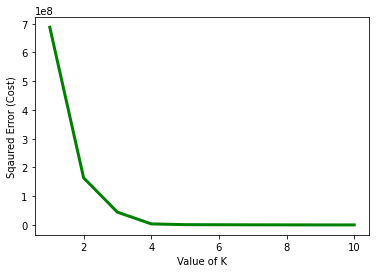

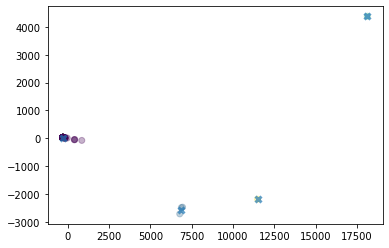

defaultdict(list,
            {1: ['bitcoin', 'wrapped-bitcoin', 'gatechain-token'],
             0: ['ethereum',
              'tether',
              'binancecoin',
              'cardano',
              'ripple',
              'dogecoin',
              'usd-coin',
              'polkadot',
              'binance-usd',
              'uniswap',
              'bitcoin-cash',
              'chainlink',
              'litecoin',
              'solana',
              'matic-network',
              'stellar',
              'ethereum-classic',
              'theta-token',
              'vechain',
              'internet-computer',
              'dai',
              'compound-usd-coin',
              'okb',
              'filecoin',
              'cdai',
              'terra-luna',
              'tron',
              'monero',
              'aave',
              'eos',
              'compound-ether',
              'ftx-token',
              'amp-token',
              'cosmos',
              

In [80]:
cost =[]
X = clustering_data
X = np.nan_to_num(X)

for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(X)
      
    # calculates squared error
    # for the clustered points
    # to find out optimal number of clusters
    cost.append(KM.inertia_)     
    
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

n_clusters = 4

model = KMeans(n_clusters=n_clusters)
model.fit(X)
centroids, labels = model.cluster_centers_, model.labels_


pca_model = PCA(n_components=2)
pca_model.fit(X) 
X_embedded = pca_model.transform(X) 

centroid_pca = pca_model.transform(centroids)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.3, c=model.labels_.astype(float))
plt.scatter(centroid_pca[:, 0], centroid_pca[:, 1], marker='x', linewidths=3, alpha=0.7)
plt.show()

predict_clusters = defaultdict(list)

for idx, x in enumerate(model.predict(np.nan_to_num(clustering_data))):
    predict_clusters[x].append(coins_data[idx][0])
predict_clusters

### Top 10 coins' cross-Correlation of Avg Price
In top 10 crpyto, Avg daily prices are highly correlated (some of them are negatively to others). Even Dogecoin price is highly correlated with other coin.  

<AxesSubplot:>

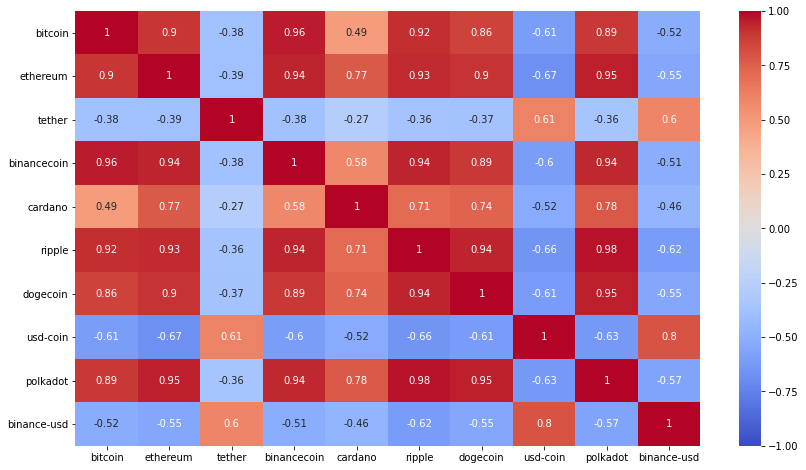

In [81]:
plt.figure(figsize=(14,8))
cross_df = pd.DataFrame(avg_price_data_np[:10].T)
sns.heatmap(cross_df.corr(),vmin=-1, vmax=1, cmap='coolwarm', annot=True, xticklabels=[coins_data[i][0] for i in range(10)], yticklabels=[coins_data[i][0] for i in range(10)])

### EDA : Daily Simple Return
Daily Simple return of Top 10 are highly correlated except few coins like tether and binance-usd (which make sense because its 1:1 usd coin and donot fluctuate)

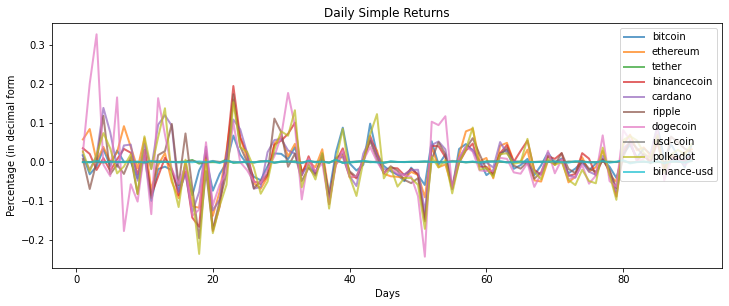

In [83]:
df = pd.DataFrame()

for idx, data in enumerate(avg_price_data_np[:10]):
    df[f"{coins_data[idx][0]}"] = data
    
df.head()
DSR = df.pct_change(1)
DSR
plt.figure(figsize=(12, 4.5))
for c in DSR.columns.values[:10]:
    plt.plot(DSR.index, DSR[c], label = c, lw = 2, alpha = .7)
plt.title('Daily Simple Returns')
plt.ylabel('Percentage (in decimal form')
plt.xlabel('Days')
plt.legend(DSR.columns.values[:10], loc= 'upper right')
plt.show()

<AxesSubplot:>

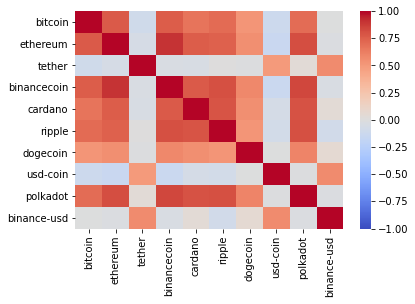

In [84]:
sns.heatmap(DSR.corr(), vmin=-1, vmax=1, cmap='coolwarm')

### Clustering Based on Simple Daily Returns

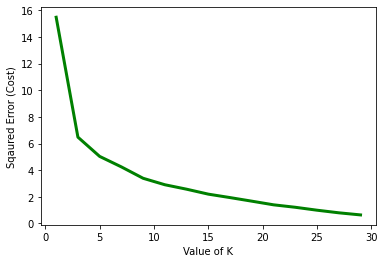

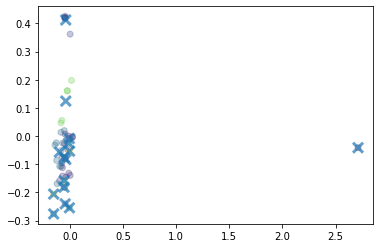

defaultdict(list,
            {11: ['bitcoin', 'wrapped-bitcoin', 'okb', 'cosmos', 'algorand'],
             2: ['ethereum',
              'binancecoin',
              'polkadot',
              'uniswap',
              'chainlink',
              'litecoin',
              'vechain',
              'compound-usd-coin',
              'cdai',
              'tron',
              'eos',
              'compound-ether',
              'amp-token',
              'shiba-inu',
              'leo-token',
              'maker',
              'axie-infinity'],
             3: ['tether',
              'usd-coin',
              'binance-usd',
              'internet-computer',
              'dai',
              'filecoin',
              'neo'],
             5: ['cardano',
              'ripple',
              'bitcoin-cash',
              'stellar',
              'terra-luna',
              'pancakeswap-token',
              'the-graph',
              'bitcoin-cash-sv',
              'klay-token',
     

In [93]:
df = pd.DataFrame()

for idx, data in enumerate(avg_price_data_np[:50]):
    df[f"{coins_data[idx][0]}"] = data

DSR = df.pct_change(1)
cost =[]
X = DSR.to_numpy()
X = X[1:].T

for i in range(1, 30, 2):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(X)
      
    # calculates squared error
    # for the clustered points
    # to find out optimal number of clusters
    cost.append(KM.inertia_)     
    
plt.plot(range(1, 30, 2), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

n_clusters = 15

model = KMeans(n_clusters=n_clusters)
model.fit(X)
centroids, labels = model.cluster_centers_, model.labels_


pca_model = PCA(n_components=2)
pca_model.fit(X) 
X_embedded = pca_model.transform(X) 

centroid_pca = pca_model.transform(centroids)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', alpha=0.3, c=model.labels_.astype(float))
plt.scatter(centroid_pca[:, 0], centroid_pca[:, 1], marker='x', linewidths=3, alpha=0.7, s=[100]*n_clusters)
plt.show()

predict_clusters = defaultdict(list)

for idx, x in enumerate(model.predict(X)):
    predict_clusters[x].append(coins_data[idx][0])
predict_clusters